# Análisis de Leche Evaporada

## Introducción 


El presente trabajo muestra un análisis de datos realizado sobre un producto de leche evaporada formato abrefácil 360 gr de una empresa mexicana. 

Dicho producto se encuentra dentro del Top 5 en el mercado de lácteos en México; además forma parte de los principales negocios y categorías para la compañía y representa el 32% de la venta mensual para la categoía de lácteos culinarios. 
 
Actualmente la empresa genera mes con mes pronósticos de demanda para cada producto de la empresa y solo utiliza como referencia los últimos 2 años anteriores al periodo actual para realizar dicha tarea.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh as bk
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import minimize
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

La información presentada en este documento es a partir de Enero 2016 a Junio 2020, se muestra de forma mensual y esta conformada por: 

a. Venta_MP: Es la venta pactada por el equipo de "Ventas" para cada cliente y que ocurrió en ese mes, la información se presenta en toneladas.

b. Pedidos: Son los pedidos realizados por los clientes directos,Sell in, la información contempla pedidos duplicados, pedidos por error. La información se presenta en toneladas.

NOTA: En algunos casos la institución bloquea los pedidos para priorizar el producto a los principales clientes.

c. PrecioxKilo: Es el precio a que se vende el producto terminado al cliente, la información se presenta en pesos mexicanos.

d. Inversión: Cantidad invertida por la compañía, equipo de "Ventas y/o Marketing", para impulsar la compra-venta del producto,la información se presenta en pesos mexicanos.

NOTA: Solo los principales productos por categoría reciben dicha inversión.

e. Stock Cover: Es el volumen almacenado por la empresa para satisfacer las necesidades futuros, la información se presenta en cajas. 

NOTA: Los datos presentados se encuentra realineados a la historia de los promocionales que hubieron en esos meses junto con la clave de línea (producto a estudiar), es decir, si hubo una promocional en el mes de Mayo entonces el total de pedidos = Pedido_clave de línea + Pedido_promocional

In [3]:
data = pd.read_csv("Historico.csv", encoding = "latin-1", index_col = 0) 
data.head()

,Venta_MP,Pedidos,PrecioxKilo,Inversion,Stock Cover
Mes,,,,,
01/01/2016,7078,4471,2453,19666,152233
02/01/2016,6670,3798,2569,25038,135569
03/01/2016,6033,3729,2778,17937,398872
04/01/2016,6314,4085,3599,17033,188782
05/01/2016,8056,5701,4266,33667,196359


In [4]:
data.shape

(54, 5)

Por lo tanto se tienen 54 meses de historia y 5 variables en la base de datos

In [5]:
data.index = pd.to_datetime(data.index)
data.index.dtype

dtype('<M8[ns]')

In [6]:
data.dtypes

Venta_MP       int64
Pedidos        int64
PrecioxKilo    int64
Inversion      int64
Stock Cover    int64
dtype: object

In [7]:
vnt = data["Venta_MP"].resample("M").sum()
pds = data["Pedidos"].resample("M").sum()
pxk = data["PrecioxKilo"].resample("M").sum()
inv = data["Inversion"].resample("M").sum()/10
stc = data["Stock Cover"].resample("M").sum()

In [8]:
data.describe()

,Venta_MP,Pedidos,PrecioxKilo,Inversion,Stock Cover
count,54.000000,54.000000,54.000000,54.000000,54.000000
mean,6434.037037,6220.703704,3458.851852,27927.981481,288098.259259
std,1201.065140,1392.573437,889.051231,8048.541442,100163.802805
min,3147.000000,3329.000000,2073.000000,13558.000000,102998.000000
25%,5726.250000,5197.750000,2866.500000,21661.750000,201240.000000
50%,6416.500000,6275.500000,3280.500000,27560.000000,284641.500000
75%,7244.750000,7238.500000,3837.500000,32938.250000,366117.500000
max,8943.000000,9255.000000,6598.000000,50931.000000,491958.000000


Todas las variables se encuentran con información completa. Al calcular el coeficiente de correlación podemos notar:

### H1: Existe una correlación directa entre las variables Venta_MP, Pedidos e Inversión

In [9]:
data.corr()

,Venta_MP,Pedidos,PrecioxKilo,Inversion,Stock Cover
Venta_MP,1.000000,0.802661,0.081870,0.674575,-0.374756
Pedidos,0.802661,1.000000,0.199260,0.742042,-0.247925
PrecioxKilo,0.081870,0.199260,1.000000,0.165829,0.030170
Inversion,0.674575,0.742042,0.165829,1.000000,-0.228917
Stock Cover,-0.374756,-0.247925,0.030170,-0.228917,1.000000


Existe una correlación positiva entre las variables Venta_MP, Pedidos e Inversión, principalmente entre Ventas_MP y Pedidos 

Para el caso de Stock Cover se puede observar una ligera correlación negativa respecto a las demás variables Venta_MP, Pedidos e Inversión

La única variable que no tiene  relación aparente con las demás variables

Text(0.5, 1.0, 'Boxplot Stock Cover')

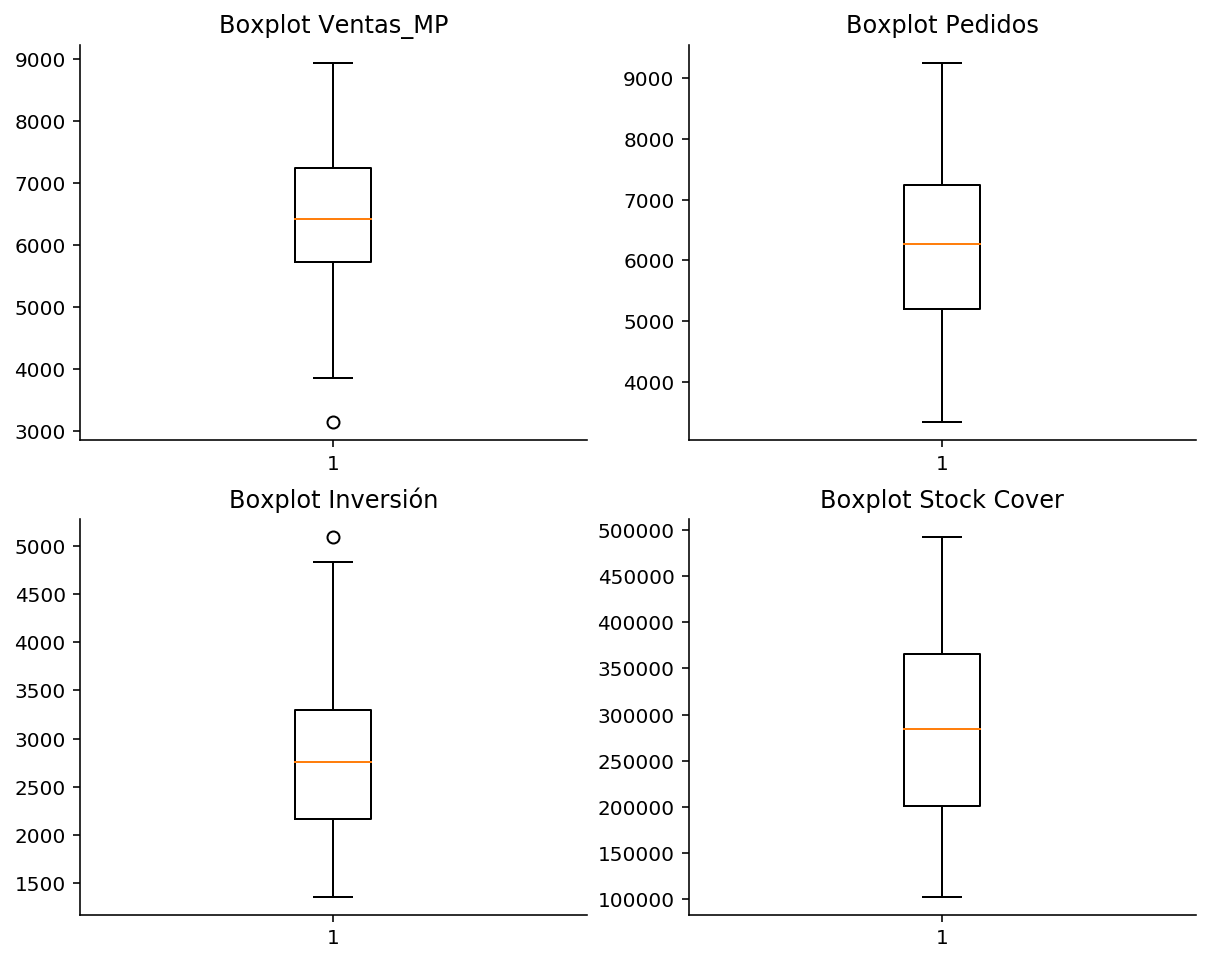

In [10]:
figure, ax = plt.subplots(2, 2, figsize= (10,8))
ax[0,0].boxplot(vnt)
ax[0,1].boxplot(pds) 
ax[1,0].boxplot(inv)
ax[1,1].boxplot(stc) 
ax[0,0].set_title("Boxplot Ventas_MP")
ax[0,1].set_title("Boxplot Pedidos")
ax[1,0].set_title("Boxplot Inversión")
ax[1,1].set_title("Boxplot Stock Cover")

Analisisi boxplot:

a. Ventas_MP: La mayoría de las ventas ocurridas en el periodo de valuación se encuentran por arriba de la media, es decir, que la mayor parte del tiempo la demanda del producto está por arriba de 6,400 toneladas. Además solo hubo un mes donde la venta generada fue atípica y no pertenece a la venta promedio de la clave

b. Pedidos: Los pedidos ocurridos en el periodo de valuación se encuentran distribuidos equilibradamente entre el 1er cuantil y el 3er cuantil, es decir, que la demanda del producto se encuentra entre las 5,100 toneladas y 7,200 toneladas al mes.

c. Inversión: La mayoría de la cantidad invertida en el periodo de valuación se encuentran por abajo de la media, es decir, que la mayor parte del tiempo la inversión se encuentra entre 21,600 pesos y 27,500 pesos. Además solo hubo un mes donde la cantidad invertida fue atípica ya que fue más del doble de lo invertido normalmente (50,900 pesos)

d. Stock Cover: Las cajas almacenadas en el periodo de valuación se encuentran distribuidos equilibradamente entre el 1er cuantil y el 3er cuantil, es decir, que en promedio las cajas almacenadas del producto se encuentra entre las 201,200 cajas y 366,100 cajas al mes.

### H2: La variable Venta_MP se puede predecir a partir de los Pedidos 
### H3: La variable Inversión se puede predecir a partir de los Pedidos 
### H4: El Precioxkilo no influye en la demanda/venta del producto

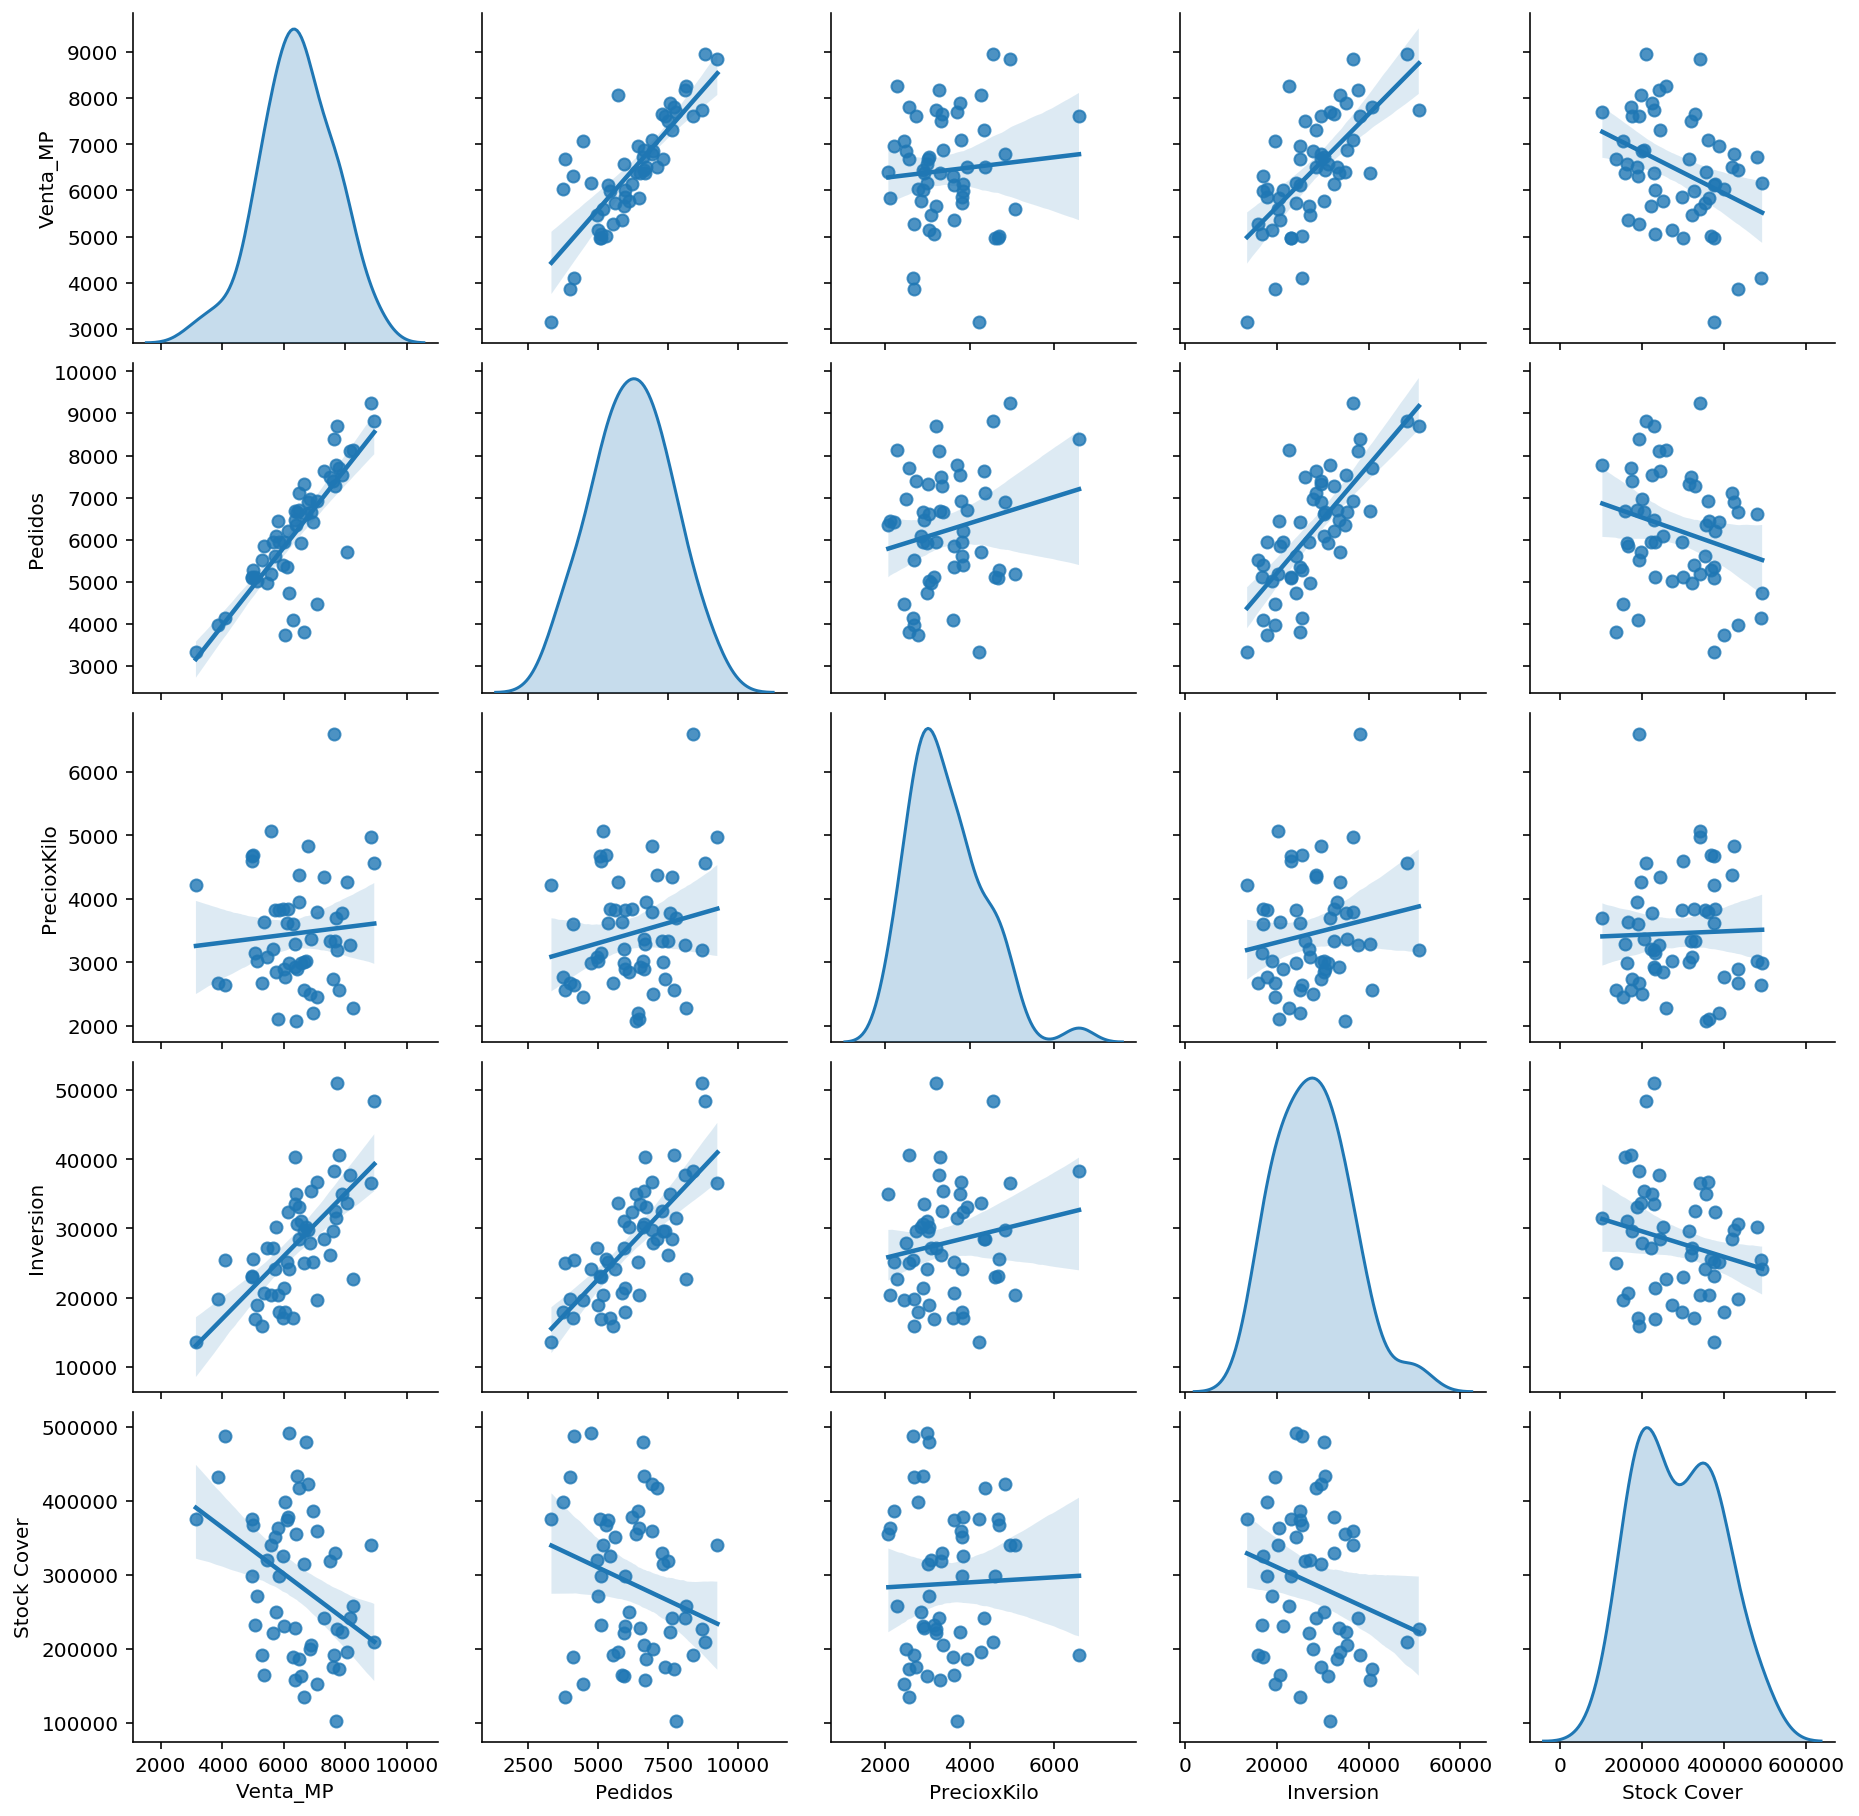

In [11]:
resume= sns.pairplot(data,diag_kind= "kde", kind = "reg")
plt.rcParams["figure.figsize"] = (10, 8)

In [12]:
def reglin(dataset):
    x = dataset[input("Ingresa el nombre de la columna que será X: ")] #obtenemos la columna con los datos de x
    y = dataset[input("Ingresa el nombre de la columna que será Y: ")] #obtenemos la columna con los datos de y
    acum = 0 #variable que acumulará la suma de (y_i - y_mean)(x_i - x_mean)
    suma2 = 0 #variable que acumulará la suma de (x_i - x_mean)^2
    y_hat = []
    res = []
    sse = []
    for i in range(0,len(dataset)): #ciclo para acumular las sumas
        num = (y[i]-y.mean())*(x[i]-x.mean())
        x_xm = (x[i]-x.mean())**2
        acum = acum + num
        suma2 = suma2 + x_xm
    beta1 = (acum)/(suma2) #obtenemos beta1
    beta0 = y.mean()-(beta1*x.mean()) #obtenemos beta0
    for i in range(0,len(dataset)):
        est = beta0+beta1*x[i]
        y_hat.append(est)
    for i in range(0,len(dataset)):
        resi = (y[i] - y_hat[i])**2
        res.append(resi)
    SSR = sum(res)
    SST = sum((y-y.mean())**2)
    for i in range(0,len(dataset)):
        err = (y_hat[i]-y.mean())**2
        sse.append(err)
    SSE = sum(sse)
    S = ((sum(res))/(len(dataset)-2))**(1/2)
    S_b0 = (S*((x**2).mean()**(1/2)))/(sum((x-x.mean())**2)**(1/2))
    S_b1 = S/(sum((x-x.mean())**2)**(1/2))
    R2 = sum(sse)/SST
    r = sum((x-x.mean())*(y-y.mean()))/((sum((x-x.mean())**2)*sum((y-y.mean())**2))**(1/2))
    print("""
    beta0 = {}
    beta1 = {}
    SSE = {}
    SST = {}
    SSR = {}
    S = {}
    R2 = {}
    r = {}
    S_b0 = {}
    S_b1 = {}""".format(beta0, beta1, SSE, SST, SSR, S, R2, r, S_b0, S_b1))

Podemos apreciar en el gráfico anterior que los datos presentados tanto  de Venta_MP, Pedidos e Inversión tienen aparentemente un comportamiento normal; a diferencia de Inversión y Stock Cover.

Y al calcular la regresión lineal para cada variable respecto a otra, se puede oservar que se podría describir el comportamiento y/o predicción de Venta_MP, Pedidos e Inversión através de una función lineal; asismismo se comprueba la relación que existe entre estas mismas variables. 

Para el caso de Stock Cover, la única variable que puede funcionar para su predicción sería Venta_MP; sin embargo, se tienen que realizar más pruebas para corroborar.

In [13]:
data_R = pd.read_csv("Historico.csv", encoding = "latin-1") 

In [14]:
reglin(data_R)

Ingresa el nombre de la columna que será X: Venta_MP
Ingresa el nombre de la columna que será Y: Pedidos

    beta0 = 232.90535988101874
    beta1 = 0.9306440589872869
    SSE = 66218023.285565265
    SST = 102780821.25925927
    SSR = 36562797.97369404
    S = 838.528908424359
    R2 = 0.6442643916858161
    r = 0.8026608198272891
    S_b0 = 627.47977190478
    S_b1 = 0.09589888168541844


Realizar un modelo de regresión lineal para explicar estás dos variables funcionaría ya que el valor del r^2 muestra que el 64% de la variable de y sería explicado por un modelo de regresión.

Esto tiene sentido ya que la variable de Ventas_MP son los acuerdos realizados por los clientes y el equipo de Ventas durante ese mes, es  decir, esos tratos se verán reflejados en los pedidos mensuales.

In [16]:
reglin(data_R)

Ingresa el nombre de la columna que será X: Venta_MP
Ingresa el nombre de la columna que será Y: Inversion

    beta0 = -1156.727956013805
    beta1 = 4.520444826486295
    SSE = 1562324846.0580835
    SST = 3433288024.981482
    SSR = 1870963178.9233987
    S = 5998.338197629597
    R2 = 0.45505207681097776
    r = 0.6745754789576758
    S_b0 = 4488.617919123146
    S_b1 = 0.6860036897290784


Realizar un modelo de regresión lineal para explicar estás dos variables funcionaría muy poco ya que el valor del r^2 muestra que el 45% de la variable de y sería explicado por un modelo de regresión.

In [17]:
reglin(data_R)

Ingresa el nombre de la columna que será X: Pedidos
Ingresa el nombre de la columna que será Y: Inversion

    beta0 = 1249.1465822071295
    beta1 = 4.288716545587956
    SSE = 1890456855.4464886
    SST = 3433288024.981482
    SSR = 1542831169.5349925
    S = 5447.001944498023
    R2 = 0.5506257679784047
    r = 0.7420416214596083
    S_b0 = 3423.4752790906296
    S_b1 = 0.5372810071240063


Realizar un modelo de regresión lineal para explicar estás dos variables funcionaría ya que el valor del r^2 muestra que el 55% de la variable de y sería explicado por un modelo de regresión.

La inversión como ya se mencionó anteriormente es la cantidad invertida por la misma empresa para impulsar la compra-venta del producto, por lo tanto, al ofrecer un descuento y/o hacer más atractivo la venta los pedidos incrementarán. 

In [19]:
reglin(data_R)

Ingresa el nombre de la columna que será X: Stock Cover
Ingresa el nombre de la columna que será Y: Venta_MP

    beta0 = 7728.665462882061
    beta1 = -0.004493704436721322
    SSE = 10737581.84686715
    SST = 76455545.92592591
    SSR = 65717964.07905878
    S = 1124.1917103058363
    R2 = 0.14044215781639013
    r = -0.3747561311258164
    S_b0 = 469.7610287880699
    S_b1 = 0.0015416707731769359


Realizar un modelo de regresión lineal para explicar estás dos variables no funcionaría ya que el valor del r^2 muestra que el solo el 14% de la variable de y sería explicado por un modelo de regresión.

Esto argumenta la poca correlación de la variable de Stock Cover con Venta_MP 

## Análisis de canales de venta

In [20]:
canal_P = pd.read_csv("Canal_AM.csv", encoding = "latin-1") 
canal_S = pd.read_csv("Canal_Resto.csv", encoding = "latin-1") 

Se segmentó la información de los canales de ventas en 2 (canal_P y canal_S), de acuerdo al volumen vendido por mes. 

Los principales canales de venta son el canal de Autoservicios y Mayoreo; los secundarios son Canales en Expansión, Conveniencia y DSD

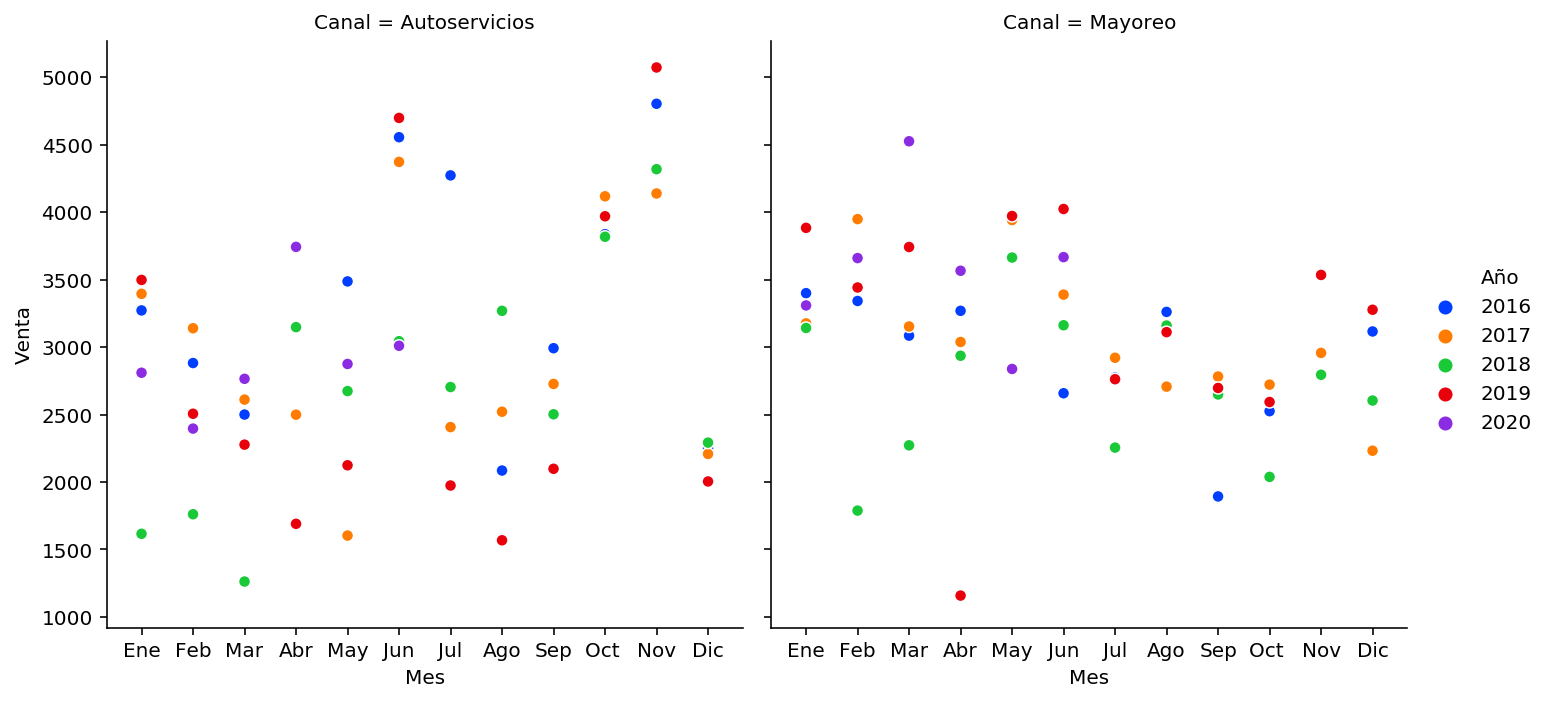

In [21]:
principal = sns.relplot(x = "Mes", y = "Venta", hue = "Año",col = "Canal", data = canal_P, palette="bright")

Se puede observar que la venta del canal de Autoservicios no es tan estable y tiende a variar respecto a cada mes; aunque existen meses particulares en donde la demanda del producto es mucho mayor versus el canal de Mayoreo (Junio, Octubre y Noviembre). 

Para el canal de Mayoreo se aprecia que la venta promedio va entre las 2,500 toneladas y 4,000 toneladas por mes, siendo los meses principales Abril, Mayo y Junio (segundo trimestre del año); además podemos notar que el canal compra más producto en el primer semestre de cada año.

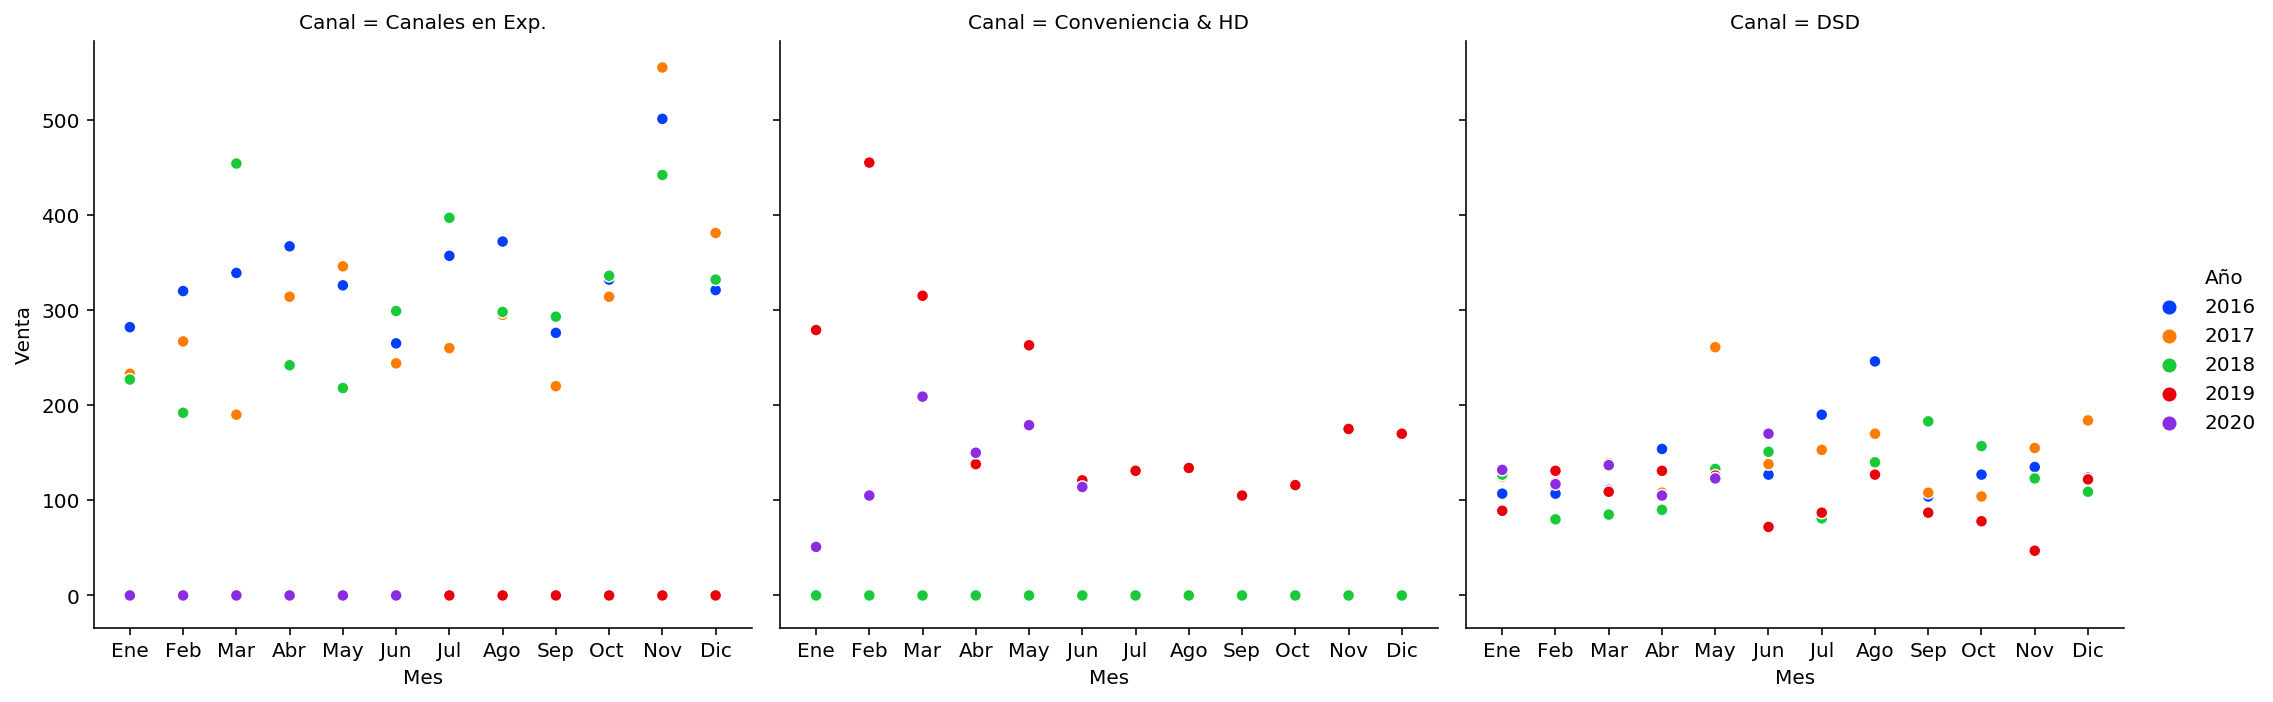

In [22]:
secundario = sns.relplot(x = "Mes", y = "Venta", hue = "Año",col = "Canal", data = canal_S, palette="bright")

Para los demás canales se observa un comportamiento menos estable ya que Canales en Expansión a dejado de vender el producto en estos últimos dos años versus el canal de Conceniencia que ha iniciado con la compra-venta del producto. 

Por el contrario, el canal de DSD mantiene la demanda entre 100 - 200 toneladas.

## Comportamiento de venta

In [105]:
data["Pedidos"].idxmin() 

Timestamp('2019-04-01 00:00:00')

La caída de venta ocurrida en el mes de abril del 2019 se debe al cambio de formato que hubo en el producto. Para el canal de mayoreo se vendía el producto sin presentación abrefácil, el cuál disminuia el costo para el cliente; sin embargo, para ese año se la compañía decidío cambiar la presentación del producto y generalizarlo para todos los canales el formato de abrefácil.

Entonces para abril, los clientes pertenecientes al canal de Mayoreo no compraron producto para vaciar sus almacenes del formato viejo.

In [26]:
data["Pedidos"].idxmax()

Timestamp('2019-11-01 00:00:00')

El cambio de formato, generó nuevos clientes que provocaron una demanda adicional a la prevista por parte del planeador de la demanda.

### H5: Los comportamientos de Venta_MP, Pedidos e Inversión son similares
### H6: Existe estacionalidad en los meses de Junio y Noviembre

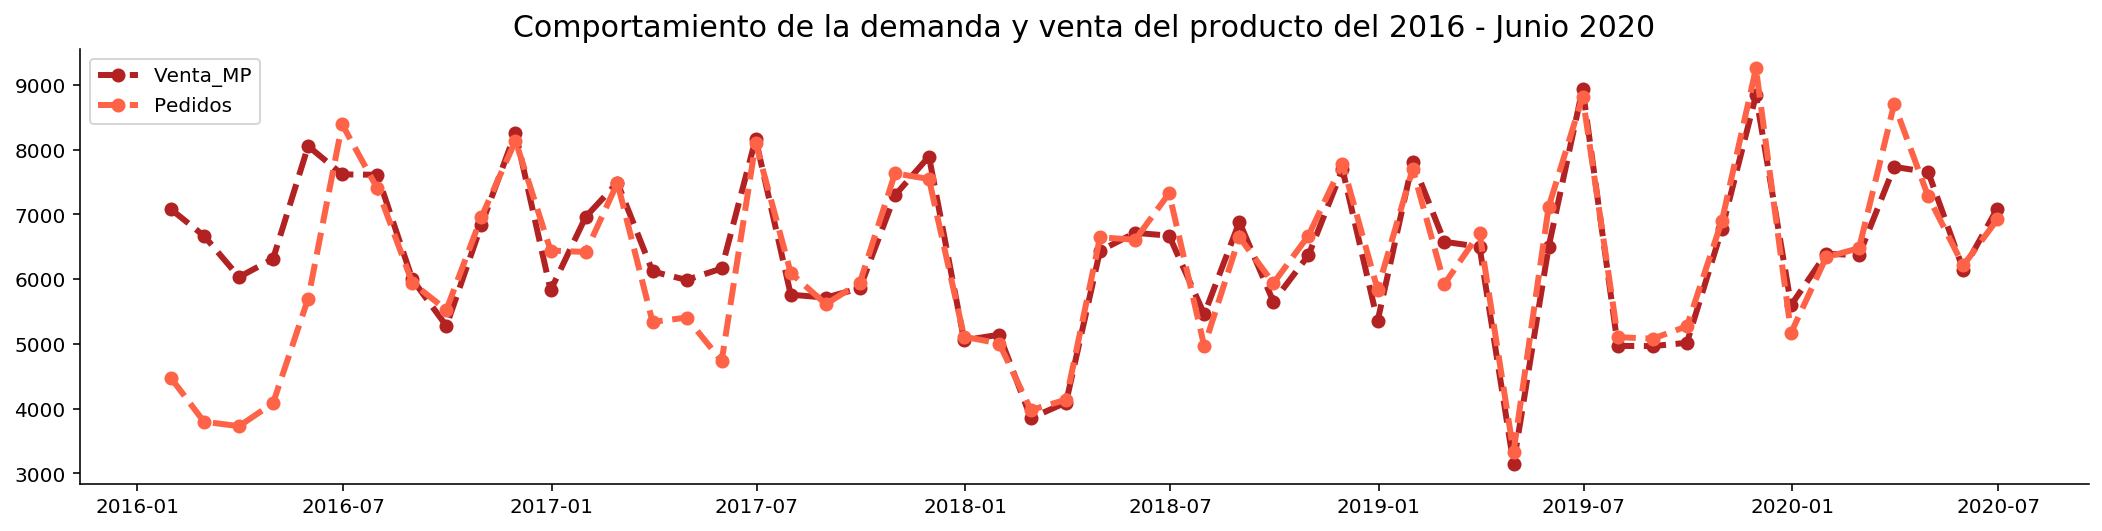

In [23]:
plt.figure(figsize= (18,4))
plt.plot(vnt,marker="o",color="firebrick", linewidth=3, linestyle="--", label="Venta_MP")
plt.plot(pds,marker="o",color="tomato", linewidth=3, linestyle="--", label="Pedidos")
plt.title("Comportamiento de la demanda y venta del producto del 2016 - Junio 2020",fontsize=15)
plt.legend(loc="upper left")
plt.show()

### H7: Existe una tendencia de crecimiento de leche evaporada

Text(0.5, 1.0, 'Total de Venta Anual, 2016 - 2019')

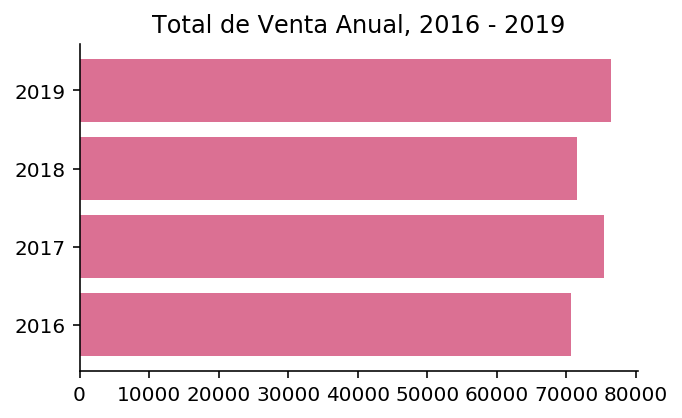

In [95]:
plt.figure(figsize= (5,3))
venta2016 = pds["2016"].sum() 
venta2017 = pds["2017"].sum() 
venta2018 = pds["2018"].sum() 
venta2019 = pds["2019"].sum() 
año  = [2016,2017,2018,2019]
total_venta = [venta2016, venta2017, venta2018, venta2019]
c_2017= ((venta2017/venta2016)-1)*100
c_2018= ((venta2018/venta2017)-1)*100
c_2019= ((venta2019/venta2018)-1)*100
porcentaje_anual = [c_2017, c_2018, c_2019]
plt.barh( año,total_venta,color="palevioletred")
plt.title("Total de Venta Anual, 2016 - 2019")

In [98]:
porcentaje_anual # 2016 - 2017, 2017 - 2018, 2018 - 2019

[6.870758900111906, -5.149856175187894, 6.771109930961239]

A pesar de la caída de demanda en el 2018, existe un notable crecimiento en la venta del producto. El cual en promedio son 5,000 toneladas más por año, lo que representa en un crecimiento anual de 6.5%

Ya que solo se cuenta con el primer semestre del 2020, se evaluará el comportamiento de los dos semestres por año:

NOTA: Llamaremos H1 al primer semestre de cada año y H2 al segundo

Text(0.5, 1.0, 'Venta del H2, 2016 - 2020')

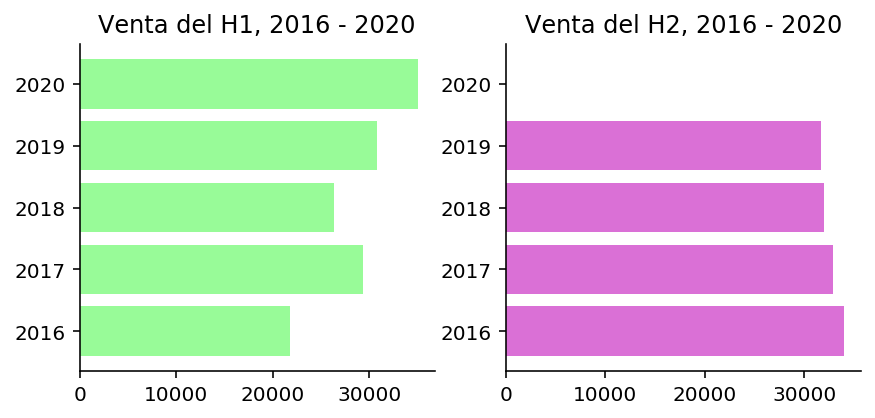

In [104]:
figure, ax = plt.subplots(1, 2, figsize= (7,3))
H1_2016 = pds["2016-01-01":"2016-06-01"].sum()
H1_2017 = pds["2017-01-01":"2017-06-01"].sum()
H1_2018 = pds["2018-01-01":"2018-06-01"].sum() 
H1_2019 = pds["2019-01-01":"2019-06-01"].sum() 
H1_2020 = pds["2020-01-01":"2020-06-01"].sum()
H2_2016 = pds["2016-07-01":"2016-12-01"].sum()
H2_2017 = pds["2017-07-01":"2017-12-01"].sum()
H2_2018 = pds["2018-07-01":"2018-12-01"].sum() 
H2_2019 = pds["2019-07-01":"2019-12-01"].sum() 
H2_2020 = 0
año = [2016,2017,2018,2019, 2020]
VentaH1_total = [H1_2016, H1_2017, H1_2018, H1_2019,H1_2020]
VentaH2_total = [H2_2016, H2_2017, H2_2018, H2_2019,H2_2020]
ax[0].barh(año, VentaH1_total, color = "palegreen")
ax[1].barh(año, VentaH2_total, color = "orchid") 
ax[0].set_title("Venta del H1, 2016 - 2020")
ax[1].set_title("Venta del H2, 2016 - 2020")

Gracias a las gráficas se puede decir que el semestre donde existe más demanda del producto y es más estable es el segundo, esto se debe al alto consumo que existe en fiestas patrias y fiestas de decembrinas. 

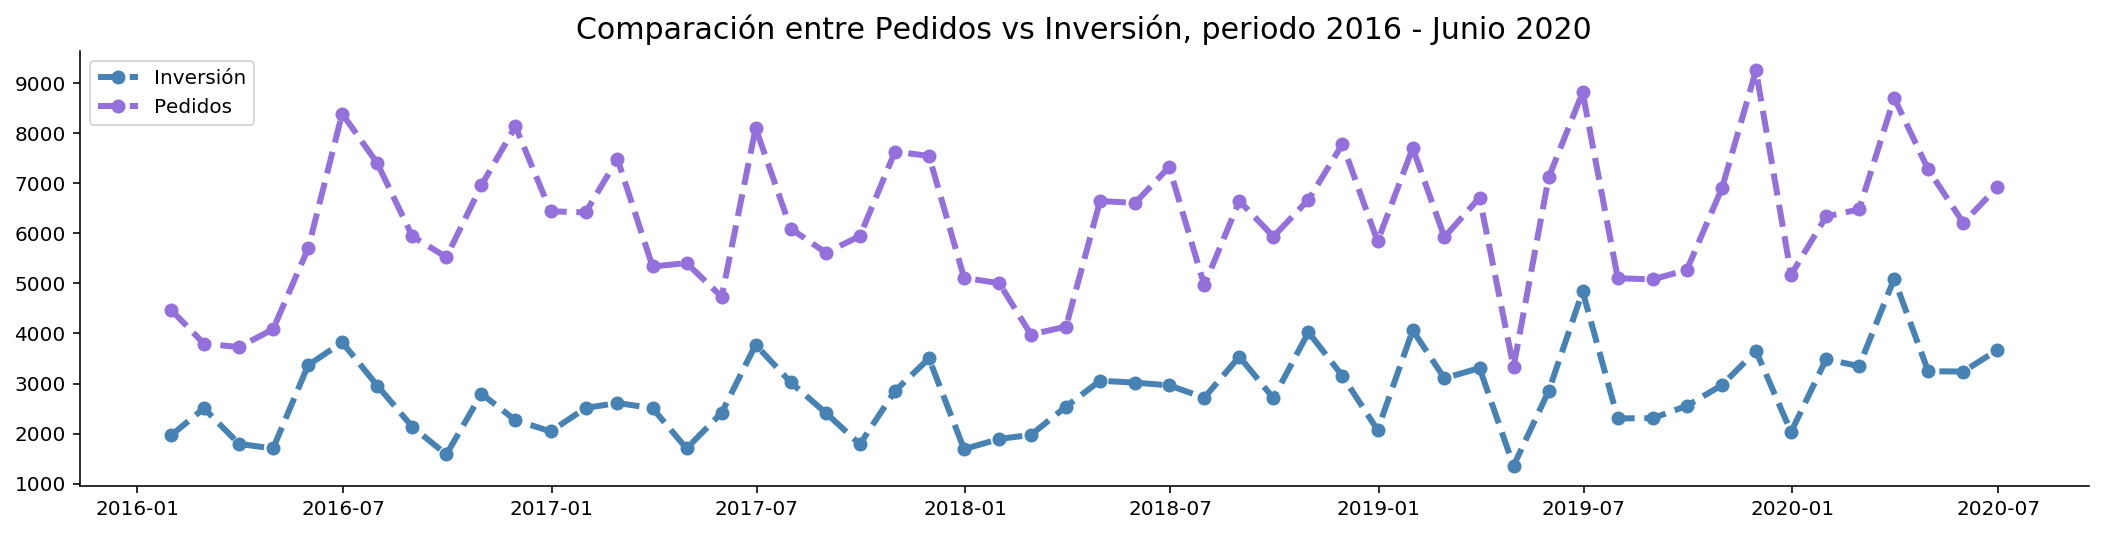

In [28]:
plt.figure(figsize= (18,4))
plt.plot(inv,marker="o",color="steelblue", linewidth=3, linestyle="--", label="Inversión")
plt.plot(pds,marker="o",color="mediumpurple", linewidth=3, linestyle="--", label="Pedidos")
plt.title("Comparación entre Pedidos vs Inversión, periodo 2016 - Junio 2020",fontsize=15)
plt.legend(loc="upper left")
plt.show()

Los comportamientos entre inversión y pedidos son muy parecidos, esto nos muestra que a mayor inversión entonces mayor es la venta generada en ese mes. 